# Variational quantum eigensolver for H$_2$ molecule

## Author
Yu-Ping Lin

## Objectives

Quantum chemistry simulation has been recognized as a promising application domain of quantum computing. In this Notebook, we follow an [IBM Qiskit course](https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe) to apply the variational quantum eigensolver (VQE), a powerful hybrid classical-quantum algorithm in the noisy intermediate-scale quantum (NISQ) era, to the dissociation problem of H$_2$ molecule. We first use PySCF to obtain the exact dissociation energy curve of H$_2$ from full configuration interaction (FCI), a classical exact algorithm. To apply quantum computing to this problem, an effective fermionic Hamiltonian is generated and mapped to a qubit Hamiltonian. We then program VQE with Qiskit and run the computation on a Qiskit Aer simulator, with the noise model obtained from an IBM quantum computer. The dissociation energy curve obtained by VQE is consistent with the exact one up to the noise.

## 1. Exact analysis of H$_2$ molecule model

We first study the H$_2$ molecule with the full configuration interaction, a classical exact algorithm in quantum chemistry. Here we use the quantum-chemistry library [PySCF library](https://pyscf.org/) to perform the computation. The modules we import include:
- gto: Gaussian-type orbitals
- scf: Self-consistent field calculations
- mcscf: Multi-configuration self-consistent field calculations

In [1]:
from pyscf import gto, scf, mcscf

Here we construct the full configuration interaction (FCI) model for H$_2$ as a function of interatomic distance. We first construct the molecule as a ``got.Mole()`` instance. A Hartree-Fock (HF) model is then constructed from the molecule. To further construct the FCI model, we use the complete active-space CI (CASCI), with the active space covering all of the two molecular orbitals.

In [2]:
def H2(distance):
    """
    Define the FCI model of H2 as a function of distance.
    Input: float, distance.
    Output: mcscf.CASCI instance, FCI model.
    """
    # ----------
    # Construct the molecule.
    # ----------
    # Define the coordinates of the H atoms.
    a = distance / 2
    # Construct the molecule.
    # atom: atom coordinates
    # basis: "sto-6g" means constructing the molecular orbitals from a minimal basis of 6 Slater-type GTOs at each atom.
    #        Here the GTOs are 1s orbitals with different radial exponential parameters.
    # spin and charge: Define the total spin and charge of unpaired electrons.
    # symmetry: "Dooh" means assigning the D_{infinity h} symmetry to the molecule, often used for homodiatomic molecules.
    mol = gto.Mole()
    mol.build(verbose=0, atom=[["H", (0, 0, -a)], ["H", (0, 0, a)]], basis="sto-6g", spin=0, charge=0, symmetry="Dooh")
    # ----------
    # Construct the FCI model.
    # ----------
    # Construct the restricted Hartree-Fock model.
    model_hf = scf.RHF(mol).run()
    # Construct the FCI model from CASCI.
    # ncas: Number of active-space orbitals. Here 2 means we include all of the two molecular orbitals, making the CASCI an FCI.
    # nelecas: Number of active-space electrons. Here (1, 1) means we assign 1 alpha (spin-up) and 1 beta (spin-down) electrons.
    model_casci = mcscf.CASCI(model_hf, ncas=2, nelecas=(1, 1))
    return model_casci

Having defined the FCI model for H$_2$ molecule, we compute the exact dissociation energy across varying distances. We consider the distances from 0.1 to 1.3:

In [3]:
import numpy as np

distances = np.linspace(0.1, 1.3, 13).round(1)

The dissociation energies can be computed as follows:

In [4]:
Es_casci = []

for distance in distances:
    # Construct the FCI model.
    model_casci = H2(distance)
    # Define the list of active-space orbitals.
    orbitals_as = range(2)
    # Get the re-ordered molecular orbitals that obey the core-active-virtual order.
    # orbitals_as: A list of active-space orbitals.
    # base: 0 means the list is in the C-style.
    mol_orbs = model_casci.sort_mo(orbitals_as, base=0)
    # Compute the total energy of the FCI model by the kernel method. Here the re-ordered molecular orbitals are used.
    E = model_casci.kernel(mol_orbs)[0]
    # Add the energy to the data list.
    Es_casci.append(E)

Having computed the dissociation energy of H$_2$, we can plot it as a function of distance to get the dissociation energy curve.

In [5]:
import matplotlib.pyplot as plt

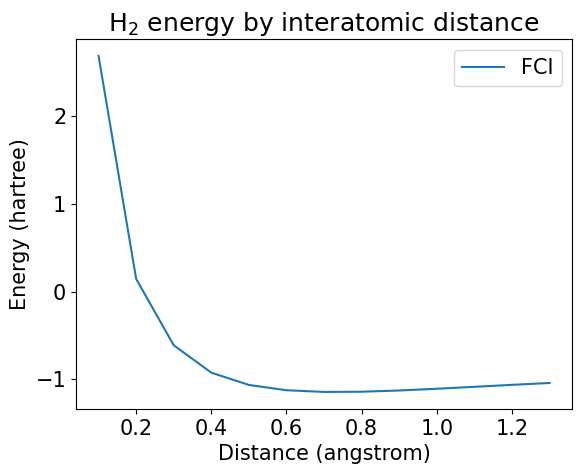

In [23]:
plt.plot(distances, Es_casci, label="FCI")
plt.rcParams.update({'font.size':15})
plt.xlabel("Distance (angstrom)")
plt.ylabel("Energy (hartree)")
plt.title("H$_2$ energy by interatomic distance")
plt.legend()
plt.show()

From the dissociation energy curve, we can observe that the minimal energy occurs around 0.7 angstroms. The exact value of the bond length in H$_2$ is approximately 0.74 angstroms.

## 2. Conversion to qubit model

Having identified the exact dissociation curve of H$_2$ with FCI, we now proceed to apply quantum computing to this problem. The first step is to construct the effective fermionic Hamiltonian and convert it to a qubit one.

For the effective fermionic Hamiltonian, the one- and two-electron integrals can be obtained from the FCI model:

In [7]:
from pyscf import ao2mo

def hs_eff(model_casci):
    """
    Obtain the one- and two-electron integrals from the FCI model.
    """
    # Get the one-electron integrals. 
    # h1e: Effective one-electron integral in the active space
    # ecore: Energy from the core.
    h1e, ecore = model_casci.get_h1eff()
    # Get the two-electron integrals. The ao2mo.restore() function converts the compact integrals into the 4-index forms in Chemist's notation.
    # symmetry: 1 means no symmetry for the output form.
    # eri: The input compact integral model_casci.get_h2eff().
    # norb: The number of orbitals model_casci.ncas.
    h2e = ao2mo.restore(1, model_casci.get_h2eff(), model_casci.ncas)
    return h1e, ecore, h2e

Having obtained the effective fermionic Hamiltonian, we want to convert it to a qubit Hamiltonian for the processing on quantum computers. Here we start to use the Qiskit library for the qubit operators. A broadly applicable class in Qiskit for the qubit operators is ``SparsePauliOp``:

In [8]:
from qiskit.quantum_info import SparsePauliOp

Using this class, we can define an identity operator at the size of the qubit system:

In [9]:
def identity(N):
    """
    Creates an identity operator at the size of the qubit system.
    """
    return SparsePauliOp.from_list([("I" * N, 1)])

An important step is to map the fermionic operators to qubit operators. There are several ways to perform this mapping. Here we choose the classic Jordan-Wigner transformation:
$$
c_j^\dagger = \prod_{k<j}Z_k\left(\frac{X_j+iY_j}{2}\right), \quad c_j^\dagger = \prod_{k<j}Z_k\left(\frac{X_j-iY_j}{2}\right).
$$
At each site $i$, we have defined the annihilation (creation) operator $c_i^{(\dagger)}$ and the Pauli matrices $X_i$, $Y_i$, $Z_i$. Note that the Qiskit library defines the qubits in the order
$$
q_Nq_{N-1}\dots q_2q_1.
$$
Keeping this order in mind, we define a function that creates the lists of qubit operators for the fermionic annihilation and creation operators:

In [10]:
def jordan_wigner(N):
    """
    Create the lists of qubit operators for the fermionic annihilation and creation operators.
    """
    # Define a list for fermionic annihilation operators.
    c_list = []
    # Add the qubit operators left[(X+iY)/2]right, where left = II....I and right = ZZ....Z, for the fermionic annihilation operator at each site.
    for n in range(N):
        # Generate the strings for left and right operators.
        if n == 0:
            left, right = "I" * (N - 1), ""
        elif n == N - 1:
            left, right = "", "Z" * (N - 1)
        else:
            left, right = "I" * (N - 1 - n), "Z" * n
        # Compose the qubit operator left[(X+iY)/2]right and add it to the list.
        c = SparsePauliOp.from_list([(left + "X" + right, 0.5), (left + "Y" + right, -0.5j)])
        c_list.append(c)
    # Obtain the list for fermionic creation operators.
    cd_list = [c.adjoint() for c in c_list]
    return c_list, cd_list

Having defined the Jordan-Wigner transformation, we can now define a function that maps the effective fermionic Hamiltonian to a qubit Hamiltonian:

In [11]:
def qubit_model(model_casci):
    """
    Get the effective fermionic Hamiltonian from the FCI model and map it to a qubit Hamiltonian.
    """
    # ----------
    # Initial preparation.
    # ----------
    # Get the one- and two-electron integrals from the FCI model.
    h1e, ecore, h2e = hs_eff(model_casci)
    # Get the number of active-space orbitals.
    ncas = h1e.shape[0]
    # Create the lists of qubit operators for the fermionic annihilation and creation operators.
    c_list, cd_list = jordan_wigner(2 * ncas)

    # ----------
    # Add the one-electron integrals to the qubit Hamiltonian.
    # ----------
    # Initialize the qubit Hamiltonian by adding the core energy.
    H = ecore * identity(2 * ncas)
    # Add the one-electron integrals. To avoid double counting in the energy, a contribution from the two-electron integral is removed.
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
    # Add the integrals in all orbitals for both alpha and beta spin species.
    for i in range(ncas):
        for j in range(ncas):
            H += t1e[i, j] * (cd_list[i] @ c_list[j] + cd_list[ncas + i] @ c_list[ncas + j])
            
    # ----------
    # Add the two-electron integrals to the qubit Hamiltonian.
    # ----------
    # Rewrite the two-electron integrals into products of one-electron integrals.
    # This is done by the diagonalization: V (c^\dagger c) (c^\dagger c) = \sum_n v_n [V_n^\dagger (c^\dagger c)] [V_n (c^\dagger c)].
    # Here v_n and V_n are the eigenvalues and eigenvectors of the matrix V.
    # ----------
    # Reshape the rank-4 tensor h2e into a matrix for diagonalization.
    V_matrix = h2e.reshape(ncas**2, ncas**2)
    # Get the eigenvalues and eigenvectors of the matrix.
    v_values, v_vectors = np.linalg.eigh(V_matrix)
    # Transpose the rank-2 matrix of column eigenvectors to the one with row eigenvectors.
    # Then reshape to a rank-3 tensor as a list of rank-2 eigentensors.
    v_vectors = v_vectors.T.reshape(ncas**2, ncas, ncas)
    # Add the contributions from each eigenvectors.
    for n_v in range(len(v_values)):
        # Initialize the operator V_n (c^\dagger c) and its complex conjugate V_n^\dagger (c^\dagger c).
        v_qubit = 0 * identity(2 * ncas)
        v_qubit_cT = 0 * identity(2 * ncas)
        # Get the n_v-th eigentensor V_n and its complex conjugate V_n^\dagger.
        v_vector = v_vectors[n_v]
        v_vector_cT = v_vector.conj().T
        # Add the terms to the operators V_n (c^\dagger c) and V_n^\dagger (c^\dagger c) for both alpha and beta spin species.
        for i in range(ncas):
            for j in range(ncas):
                v_qubit += v_vector[i, j] * (cd_list[i] @ c_list[j] + cd_list[ncas + i] @ c_list[ncas + j])
                v_qubit_cT += v_vector_cT[i, j] * (cd_list[i] @ c_list[j] + cd_list[ncas + i] @ c_list[ncas + j])
        # Add the term v_n [V_n^\dagger (c^\dagger c)] [V_n (c^\dagger c)] to the Hamiltonian.
        H += 0.5 * v_values[n_v] * v_qubit_cT @ v_qubit

    return H.chop().simplify()

## 3. Variational quantum eigensolver

We have been able to generate an effective fermionic Hamiltonian of H$_2$ and convert it to a qubit Hamiltonian. Our next task is to build an algorithm that can find its ground state energy with the powerful support from quantum computer. The algorithm we choose here is the VQE, a powerful hybrid classical-quantum algorithm in the noisy intermediate-scale quantum (NISQ) era. It combines the well-estalished classical optimization methods and the significant reduction of computational expense from the quantum computer. Given a parametrized quantum-circuit ansatz for the qubit quantum state and the qubit Hamiltonian, the VQE iterates the classical and quantum parts back and forth:
$$
\text{Classical optimization: Circuit parameters} \quad\leftrightarrow\quad \text{Quantum estimation: State energy}
$$
The iteration continues until the estimated energy is minimized, indicating the arrival of the ground state.

To implement the VQE, we need to define the quantum circuit which will be used in the quantum computing part. We begin by defining the ansatz for the qubit quantum state. Here our choice is the preset ``efficient_su2`` class in the Qiskit library:

Circuit depth: 5


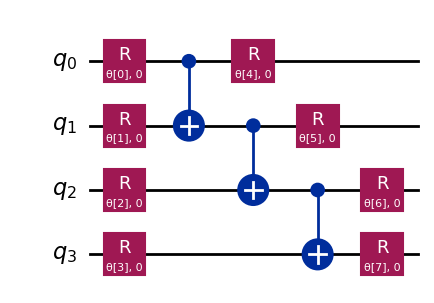

In [12]:
from qiskit.circuit.library import efficient_su2

# Get the number of qubits from a H2 model.
num_qubits = qubit_model(model_casci = H2(1)).num_qubits
# Construct the ansatz.
# num_qubits: The number of qubits to include.
# su2_gates: The single-qubit SU(2) gates to use.
# entanglement: "linear" means applying CNOT gates sequentially to the (i, i+1) qubit pairs.
# reps: The number of times to repeat the entanglement + SU(2) gates.
ansatz = efficient_su2(num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
print(f"Circuit depth: {ansatz.decompose().depth()}")
ansatz.decompose().draw("mpl")

We want to run the VQE on a quantum computer. However, the quantum circuit and the Hamiltonian may not be compatible with the quantum computer. We need to transpile them to match the instruction set architecture (ISA) of the quantum computer, which includes the available gates and connectivity between qubits.

To perform the transpilation, we first extract the backend from an IBM quantum computer:

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

Having known which quantum computer we want to transpile to, the transpilation can be done using a preset pass manager:

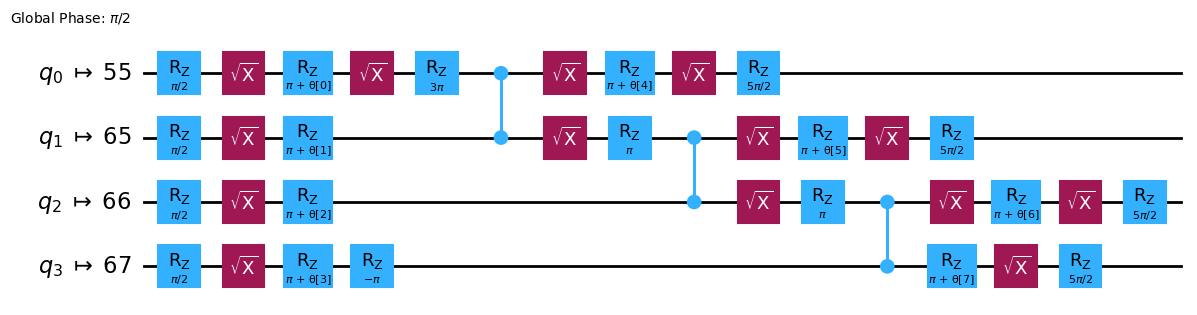

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Construct the pass manager for the transpilation, with the backend from the IBM quantum computer.
# optimization_level: 0-3 from low to high optimization of the quantum circuit.
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
# Transpile the quantum circuit with the pass manager.
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

Having finished the transpilation, the next step is to construct an estimator for the energy. Since the quantum computing time for IBM's free account is very limited, we use an estimator from Qiskit Aer library to perform the estimation. Note that we obtain a backend from the IBM's quantum computer we transpile to. This backend creates a noise model by extracting real calibration error data, thereby establishing a good basis for practical simulation:

In [15]:
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

backend_sim = AerSimulator.from_backend(backend)
estimator = BackendEstimatorV2(backend=backend_sim)

Having constructed to quantum computing part, we switch to the classical computing part and define a cost function for our optimization. The definition of this cost function is simply the energy of qubit quantum state from quantum computing estimation:

In [16]:
def cost_function(params, ansatz, H, estimator):
    """
    Cost function of the classical optimization: Energy of the qubit quantum state.
    """
    # Input of the estimator: Primitive unified bloc (PUB).
    # Circuit: The ansatz we use.
    # List of operators to measure: Our Hamiltonian [H].
    # Parameters of the circuit: [params]
    pub = (ansatz, [H], [params])
    # Perform the estimation.
    result = estimator.run(pubs=[pub]).result()
    # Get the energy from the estimation result.
    energy = result[0].data.evs[0]
    return energy

With the cost function defined, we can perform the optimization by minimizing its value. This classical process is executed by using the ``minimize`` function in SciPy:

In [17]:
from scipy.optimize import minimize

We now apply VQE to compute the dissociation energies of H$_2$:

In [20]:
Es_vqe = []

for distance in distances:
    print(f"Distance = {distance}")
    # Construct the FCI model of H2.
    model_casci = H2(distance)
    # Convert the FCI model to a qubit Hamiltonian and transpile it to practical layout.
    H = qubit_model(model_casci)
    H_isa = H.apply_layout(ansatz_isa.layout)
    # Initialize the parameters in the ansatz.
    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    # Apply the VQE.
    # cost_function: Cost function to minimize.
    # x0: Initial parameters in the ansatz.
    # args: Remaining arguments of the cost function.
    # method: "cobyla" is a gradient-descent optimization method.
    # options: "maxiter" assigns the maximal iteration number, and "disp" determines whether to print the result.
    result = minimize(cost_function, x0, args=(ansatz_isa, H_isa, estimator), method="cobyla", options={"maxiter": 50, "disp": False})
    # Get the energy from the minimization result.
    E = getattr(result, "fun")
    print(f"energy = {E}", "\n")
    # Add the energy to the list.
    Es_vqe.append(E)

Distance = 0.1
energy = 2.9024183381800452 

Distance = 0.2
energy = 0.4042763039152547 

Distance = 0.3
energy = -0.4924755398916213 

Distance = 0.4
energy = -0.8232637348333323 

Distance = 0.5
energy = -0.7494691683146536 

Distance = 0.6
energy = -1.0102745490257214 

Distance = 0.7
energy = -1.0837979320117468 

Distance = 0.8
energy = -1.0729241302945125 

Distance = 0.9
energy = -0.6626304641933262 

Distance = 1.0
energy = -0.9931697256527394 

Distance = 1.1
energy = -0.9946736332488655 

Distance = 1.2
energy = -0.9849406693644759 

Distance = 1.3
energy = -0.8752161461505841 



Having finished the VQE computation, we can compare the resulting dissociation energy curve to the exact one from classical FCI:

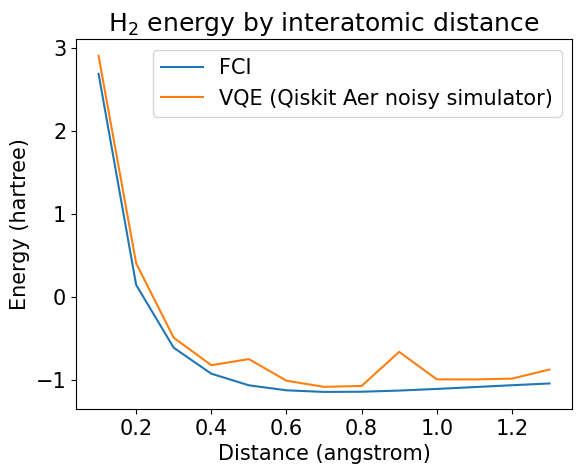

In [24]:
plt.plot(distances, Es_casci, label="FCI")
plt.plot(distances, Es_vqe, label="VQE (Qiskit Aer noisy simulator)")
plt.rcParams.update({'font.size':15})
plt.xlabel("Distance (angstrom)")
plt.ylabel("Energy (hartree)")
plt.title("H$_2$ energy by interatomic distance")
plt.legend()
plt.show()

We can see that the dissociation energy curve from VQE is very close to the one from FCI! The difference in between results from the error under the noise model.

Before we finish the work, let us store the data in a file so that we can read them in the future:

In [25]:
import joblib

data = {"distances": distances, "energy_fci": Es_casci, "energy_vqe": Es_vqe}
joblib.dump(data, "VQE_H2")

['VQE_H2']

## Discussion

We have executed a quantum chemistry simulation with a hybrid classical-quantum algorithm. Using the VQE, we have successfully obtained the dissociation energy curve of H$_2$ molecule. Due to the limitation of available quantum computing resource, we have performed the quantum computing part with the Qiskit Aer simulator under a realistic noise model. The result is consistent with the exact one from classical FCI, up to the error under the noises.

It should be noted that for the current problem of H$_2$, there are only four molecular electronic states in the active space, corresponding to four qubits in the quantum circuit. In this case, the classical FCI algorithm can perform very efficiently and outperforms the VQE. As we move on to larger molecules, the active space we need to consider can grow very fast. In this case, the classical cost of computing energy can grow exponentially, while the quantum cost can grow just polynomially. This significant reduction suggests quantum computing as a promising way to advance quantum chemistry simulation. The exploration of larger molecules on real quantum computers is an important research direction for our future work.